In [1]:
#1.Imports Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")


In [3]:
#2.Load and clean dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)


In [4]:
#3.Encoding
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Churn')
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df_encoded['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [5]:
#4.Train,Test Split
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
#5.Model Training
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("="*50)


Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

[[915 118]
 [181 193]]
Model: Random Forest
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

[[927 106]
 [196 178]]


In [7]:
#6.Churn Risk Scoring
best_model = models["Random Forest"]
df_encoded['churn_probability'] = best_model.predict_proba(X)[:,1]

def risk_level(prob):
    if prob > 0.7:
        return "High"
    elif prob > 0.4:
        return "Medium"
    else:
        return "Low"

df_encoded['Churn_Risk'] = df_encoded['churn_probability'].apply(risk_level)


In [8]:
# 7. Customer Segmentation
segment_features = df[['tenure', 'MonthlyCharges', 'TotalCharges']]
scaler = StandardScaler()
segment_scaled = scaler.fit_transform(segment_features)

kmeans = KMeans(n_clusters=4, random_state=42)
df_encoded['Segment'] = kmeans.fit_predict(segment_scaled)


In [9]:
# 8. Retention Strategy
def recommend_action(row):
    if row['Churn_Risk'] == 'High':
        if row['Segment'] == 0:
            return "Offer loyalty benefits"
        elif row['Segment'] == 1:
            return "Provide discount plan"
        else:
            return "Assign retention agent"
    elif row['Churn_Risk'] == 'Medium':
        return "Send personalized offers"
    else:
        return "No action needed"

df_encoded['Retention_Action'] = df_encoded.apply(recommend_action, axis=1)


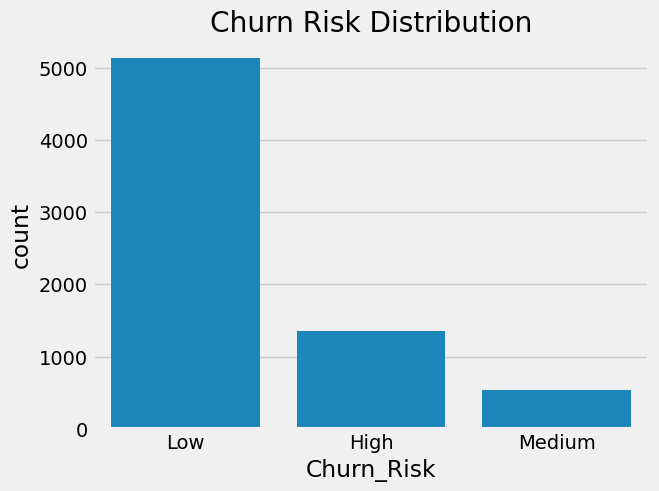

In [13]:
#9.Churn Risk Distribution
sns.countplot(x='Churn_Risk', data=df_encoded)
plt.title("Churn Risk Distribution")
plt.show()


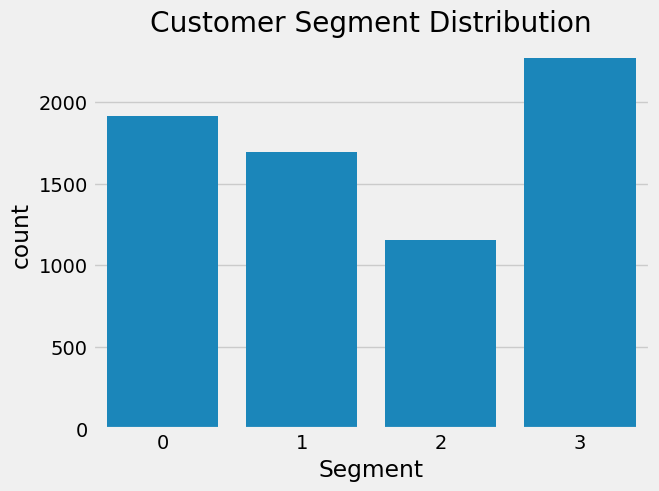

In [14]:
#10. Segment Distribution
sns.countplot(x='Segment', data=df_encoded)
plt.title("Customer Segment Distribution")
plt.show()


In [18]:
# 11. Summary View
summary = df_encoded[['churn_probability', 'Churn_Risk', 'Segment', 'Retention_Action']]
summary.head(15)


,churn_probability,Churn_Risk,Segment,Retention_Action
0,0.23,Low,1,No action needed
1,0.03,Low,2,No action needed
2,0.85,High,1,Provide discount plan
3,0.02,Low,2,No action needed
4,0.89,High,3,Assign retention agent
5,0.97,High,3,Assign retention agent
6,0.12,Low,3,No action needed
7,0.13,Low,1,No action needed
8,0.63,Medium,3,Send personalized offers
9,0.03,Low,2,No action needed


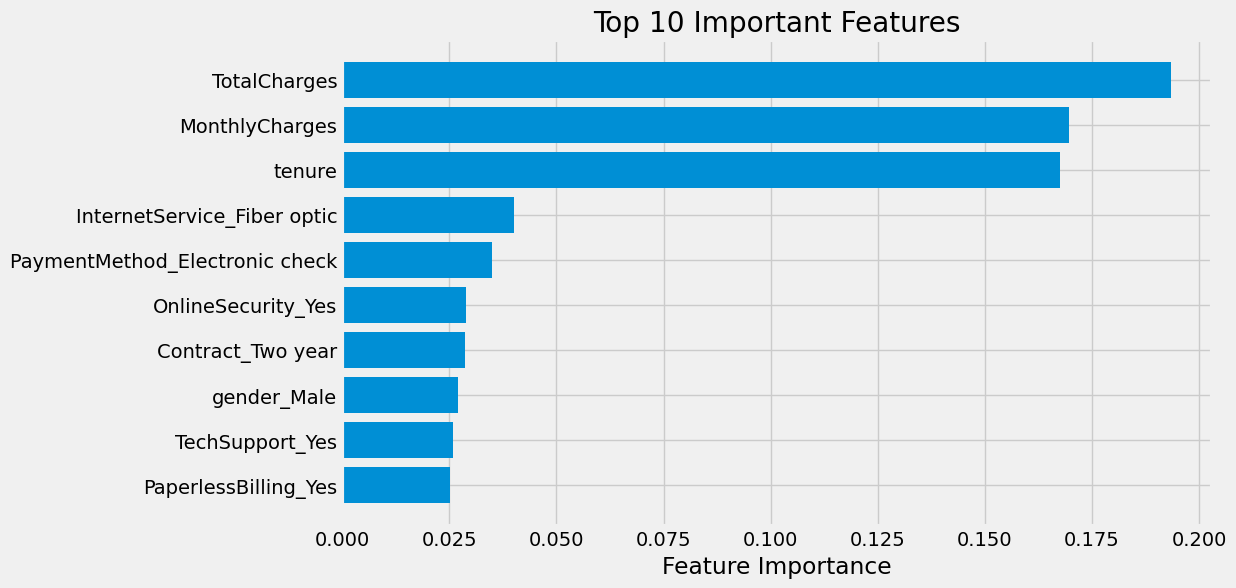

In [11]:

# 12. Feature Importance Plot
importances = best_model.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(10,6))
plt.title("Top 10 Important Features")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.show()
